In [1]:
from mmetro import Mmetro_Utils, Kalman
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import speed_of_light
import pickle
import pandas as pd
import glob
import os
from pprint import pprint
from datetime import datetime
from progressbar import ProgressBar, Bar, Percentage
from ipywidgets import IntProgress
from IPython.display import display
from scipy import signal
from matplotlib.ticker import MaxNLocator
import matplotlib as mpl

In [2]:
dir = '/Users/ryuokubo/mmetro/Data/'
names = [x for x in glob.glob(dir + '*ryu_motion3-24GHz.pickle')]
names.sort()
pprint(names)
names_outdoor = [x for x in glob.glob(dir + '*ryu_motion4-24GHz.pickle')]
names_outdoor.sort()
pprint(names_outdoor)

['/Users/ryuokubo/mmetro/Data/230213-140854-ryu_motion3-24GHz.pickle',
 '/Users/ryuokubo/mmetro/Data/230213-141102-ryu_motion3-24GHz.pickle',
 '/Users/ryuokubo/mmetro/Data/230213-141154-ryu_motion3-24GHz.pickle',
 '/Users/ryuokubo/mmetro/Data/230213-141246-ryu_motion3-24GHz.pickle',
 '/Users/ryuokubo/mmetro/Data/230213-141341-ryu_motion3-24GHz.pickle',
 '/Users/ryuokubo/mmetro/Data/230213-141537-ryu_motion3-24GHz.pickle',
 '/Users/ryuokubo/mmetro/Data/230213-141733-ryu_motion3-24GHz.pickle',
 '/Users/ryuokubo/mmetro/Data/230213-141830-ryu_motion3-24GHz.pickle',
 '/Users/ryuokubo/mmetro/Data/230213-141931-ryu_motion3-24GHz.pickle']
['/Users/ryuokubo/mmetro/Data/230228-225015-ryu_motion4-24GHz.pickle',
 '/Users/ryuokubo/mmetro/Data/230228-225123-ryu_motion4-24GHz.pickle',
 '/Users/ryuokubo/mmetro/Data/230228-225251-ryu_motion4-24GHz.pickle',
 '/Users/ryuokubo/mmetro/Data/230228-225407-ryu_motion4-24GHz.pickle',
 '/Users/ryuokubo/mmetro/Data/230228-225516-ryu_motion4-24GHz.pickle',
 '/Use

In [3]:
good_indices = [0,2,3,4,5,6,8]
good_indices_out = [1,2,4,5]
names_good = [names[i] for i in good_indices]
names_good_outdoor = [names_outdoor[i] for i in good_indices_out]

In [4]:
utils = Mmetro_Utils(maxRange=23, switchPer = 2500e-6)

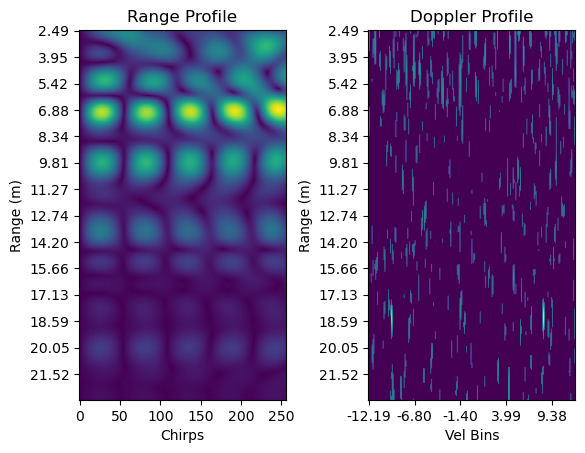

In [4]:
utils.plot_doppler(names[4], 80, save_fig = False, save_RD_norm = False, cut=15, threshold = 0.3)

('start processing '
 '/Users/ryuokubo/mmetro/Data/230228-225123-ryu_motion4-24GHz.pickle')


IntProgress(value=0, max=358)

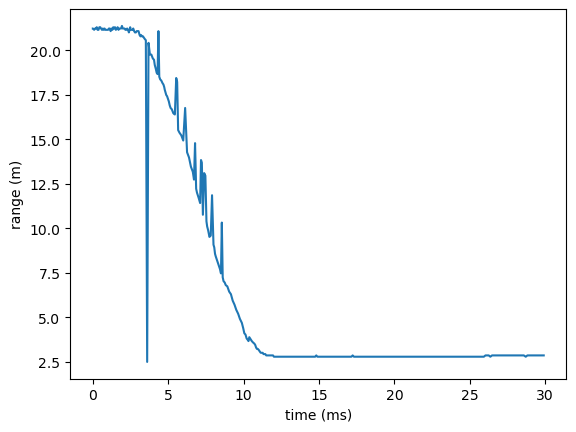

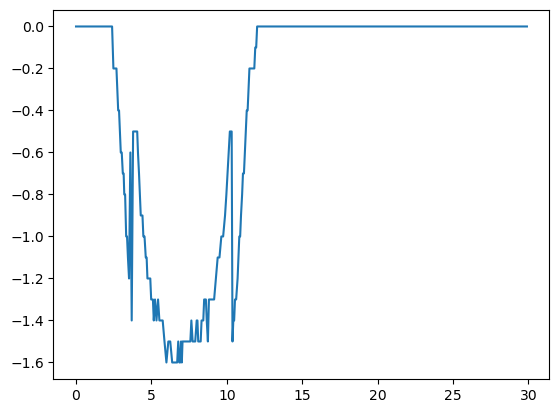

In [16]:
utils.process_plot(names_good_outdoor[0:1], cut=[5,15], threshold=0, file_name='cut_30_')

16.541283083007812

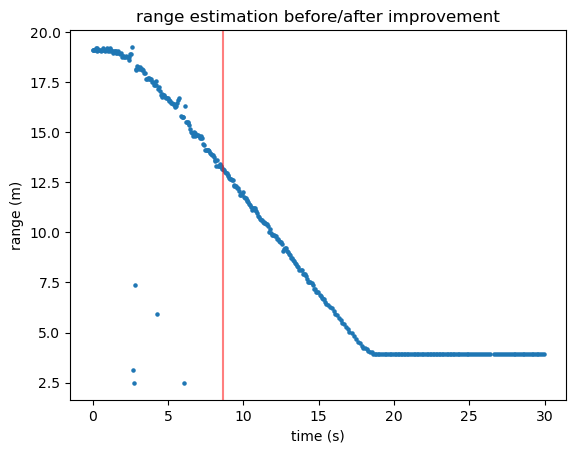

In [17]:
distance_file = 'Data/' + names[6][28:-7]+'/processed_range_time.npy'
distance_file1 = 'Data/' + names[6][28:-7]+'/processed_velocity.npy'
data = np.load(distance_file)
data1 = np.load(distance_file1)
timestamp = data[0]
distance = data[1]
plt.scatter(timestamp, distance, s=5)
plt.axvline(timestamp[150], c = 'r', alpha=0.5)
plt.title("range estimation before/after improvement")
plt.xlabel("time (s)")
plt.ylabel("range (m)")
distance[90]

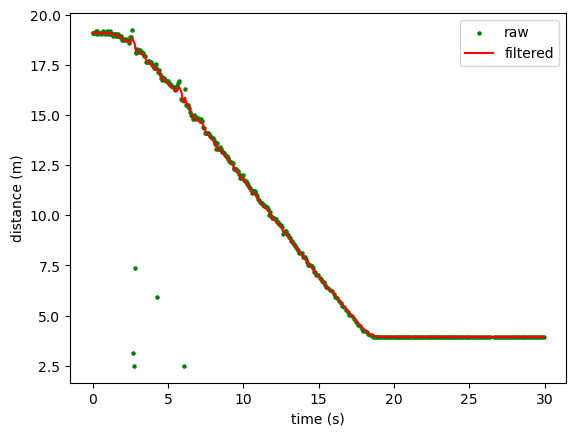

In [6]:
kalman = Kalman(threshold = 1.5)
kalman.run(names[6])

In [22]:
data_pool_in = []
data_pool_out = []
data_pool = []

for i in range(len(names_good)):
    path = 'Data/' + names_good[i][28:-7] + '/processed_data.pickle'
    with open(path, 'rb') as handle:
        data_dict = pickle.load(handle)
    data_pool_in.append(data_dict)
    data_pool.append(data_dict)
        
for i in range(len(names_good_outdoor)):
    path = 'Data/' + names_good_outdoor[i][28:-7] + '/processed_data.pickle'
    with open(path, 'rb') as handle:
        data_dict = pickle.load(handle)
    data_pool_out.append(data_dict)
    data_pool.append(data_dict)

In [23]:
data_pool_sorted_in = sorted(data_pool_in, key=lambda x: x['speed_est'])
data_pool_sorted_out = sorted(data_pool_out, key=lambda x: x['speed_est'])

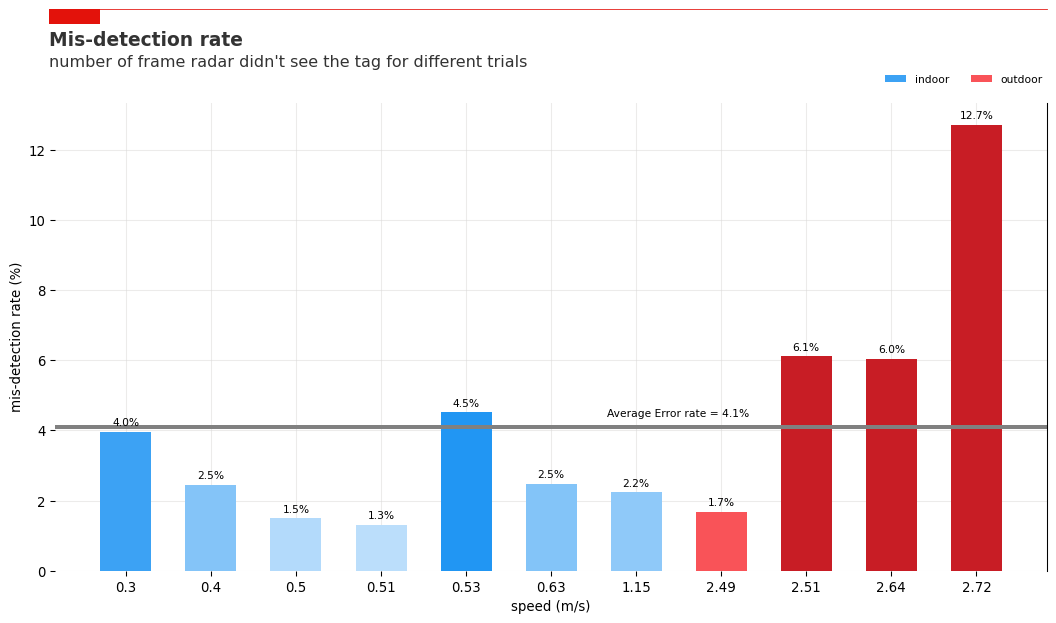

In [26]:
speed_ests1 = [str(round(data['speed_est'], 2)) for data in data_pool_sorted_in]
err_rate1 = [data['num_err'] / data['n_frame'] * 100 for data in data_pool_sorted_in]

speed_ests2 = [str(round(data['speed_est'], 2)) for data in data_pool_sorted_out]
err_rate2 = [data['num_err'] / data['n_frame'] * 100 for data in data_pool_sorted_out]

err_rate = [data['num_err'] / data['n_frame'] * 100 for data in data_pool]

fig, ax = plt.subplots(figsize=(13.33,7.5), dpi = 96)
colors_high = ["#ff5a5f", "#c81d25"] # Extreme colours of the high scale
colors_low = ["#bbdefb" , "#2196f3"] # Extreme colours of the low scale


# Colormap - Build the colour maps
cmap1 = mpl.colors.LinearSegmentedColormap.from_list("colour_map", colors_low, N=256)
cmap2 = mpl.colors.LinearSegmentedColormap.from_list("colour_map", colors_high, N=256)
norm = mpl.colors.Normalize(min(err_rate1), max(err_rate1)) # linearly normalizes data into the [0.0, 1.0] interval

# Plot bars
bar1 = ax.bar(speed_ests1, err_rate1, color=cmap1(norm(err_rate1)), width=0.6, zorder=2, label='indoor')
bar2 = ax.bar(speed_ests2, err_rate2, color=cmap2(norm(err_rate2)), width=0.6, zorder=2, label='outdoor')

ax.set_xlabel('speed (m/s)')
ax.set_ylabel('mis-detection rate (%)')
ax.grid(which="major", axis='x', color='#DAD8D7', alpha=0.5, zorder=1)
ax.grid(which="major", axis='y', color='#DAD8D7', alpha=0.5, zorder=1)

# ax.xaxis.set_label_position("bottom")
# ax.xaxis.set_major_formatter(lambda s, i : f'{s:,.0f}')
# ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.bar_label(bar1, labels=[f'{e:,.1f}%' for e in err_rate1], padding=3, color='black', fontsize=8)
ax.bar_label(bar2, labels=[f'{e:,.1f}%' for e in err_rate2], padding=3, color='black', fontsize=8)

ax.spines[['top','left','bottom']].set_visible(False)

ax.plot([0.12, .9], [.98, .98], transform=fig.transFigure, clip_on=False, color='#E3120B', linewidth=.6)
ax.add_patch(plt.Rectangle((0.12,.98), 0.04, -0.02, facecolor='#E3120B', transform=fig.transFigure, clip_on=False, linewidth = 0))

ax.text(x=0.12, y=.93, s="Mis-detection rate", transform=fig.transFigure, ha='left', fontsize=14, weight='bold', alpha=.8)
ax.text(x=0.12, y=.90, s="number of frame radar didn't see the tag for different trials", transform=fig.transFigure, ha='left', fontsize=12, alpha=.8)

plt.subplots_adjust(left=None, bottom=0.2, right=None, top=0.85, wspace=None, hspace=None)

fig.patch.set_facecolor('white')

avg_err = np.mean(err_rate)

ymin, ymax = ax.get_ylim()
plt.axhline(y=avg_err, color = 'grey', linewidth=3)
y_pos = avg_err/ymax + 0.03
ax.text(0.7, y_pos, f'Average Error rate = {avg_err:.1f}%', ha='right', va='center', transform=ax.transAxes, size=8, zorder=3)
ax.legend(loc="best", ncol=2, bbox_to_anchor=[1, 1.07], borderaxespad=0, frameon=False, fontsize=8)

Text(0.12, 0.9, 'range vs time plot comparing improvement before and after processing for speed = 0.98m/s trial')

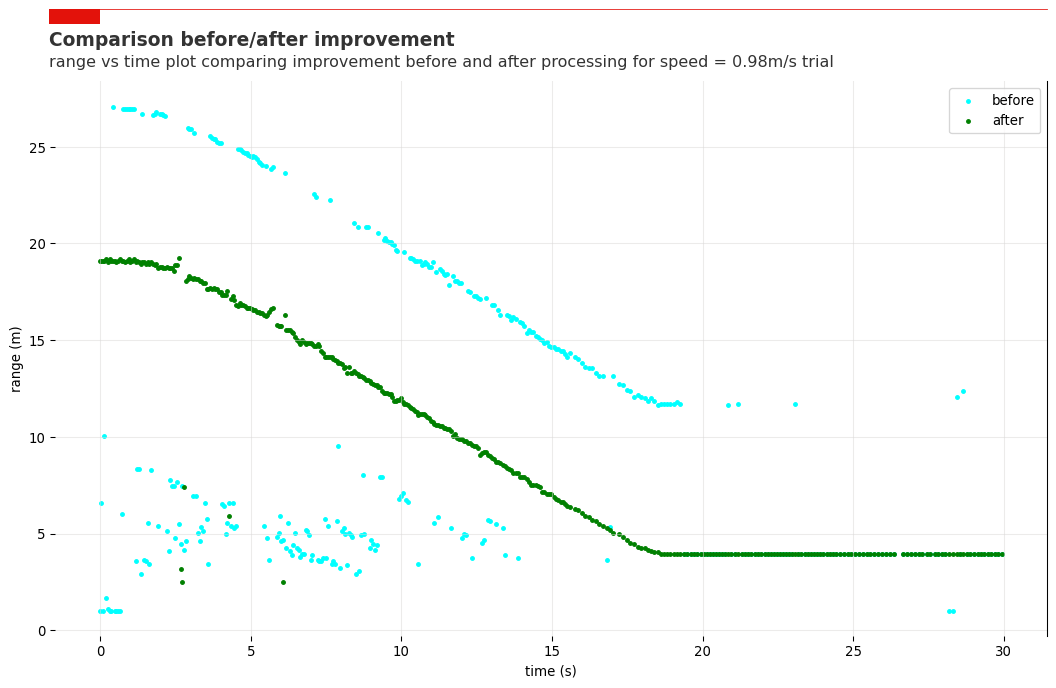

In [64]:
fig, ax = plt.subplots(figsize=(13.33,7.5), dpi = 96)

distance_file = 'Data/' + names[6][28:-7]+'/processed_range_time.npy'
distance_file1 = 'Data/' + names[6][28:-7]+'/cut_0_data.npy'
data = np.load(distance_file)
data1 = np.load(distance_file1)
timestamp = data[0]
distance = data[1]
timestamp1 = data1[0]
distance1 = data1[1]

ax.scatter(timestamp1, distance1, s=7, c = 'cyan')
ax.scatter(timestamp, distance, s=7, c='g')
ax.set_xlabel("time (s)")
ax.set_ylabel("range (m)")
ax.legend(['before', 'after'])

ax.spines[['top','left','bottom']].set_visible(False)

ax.grid(which="major", axis='x', color='#DAD8D7', alpha=0.5, zorder=1)
ax.grid(which="major", axis='y', color='#DAD8D7', alpha=0.5, zorder=1)

ax.plot([0.12, .9], [.98, .98], transform=fig.transFigure, clip_on=False, color='#E3120B', linewidth=.6)
ax.add_patch(plt.Rectangle((0.12,.98), 0.04, -0.02, facecolor='#E3120B', transform=fig.transFigure, clip_on=False, linewidth = 0))

ax.text(x=0.12, y=.93, s="Comparison before/after improvement", transform=fig.transFigure, ha='left', fontsize=14, weight='bold', alpha=.8)
ax.text(x=0.12, y=.90, s="range vs time plot comparing improvement before and after processing for speed = 0.98m/s trial", transform=fig.transFigure, ha='left', fontsize=12, alpha=.8)

Text(0.12, 0.9, 'range vs time plot comparing before and after applying post processing for speed = 0.9 m/s trial')

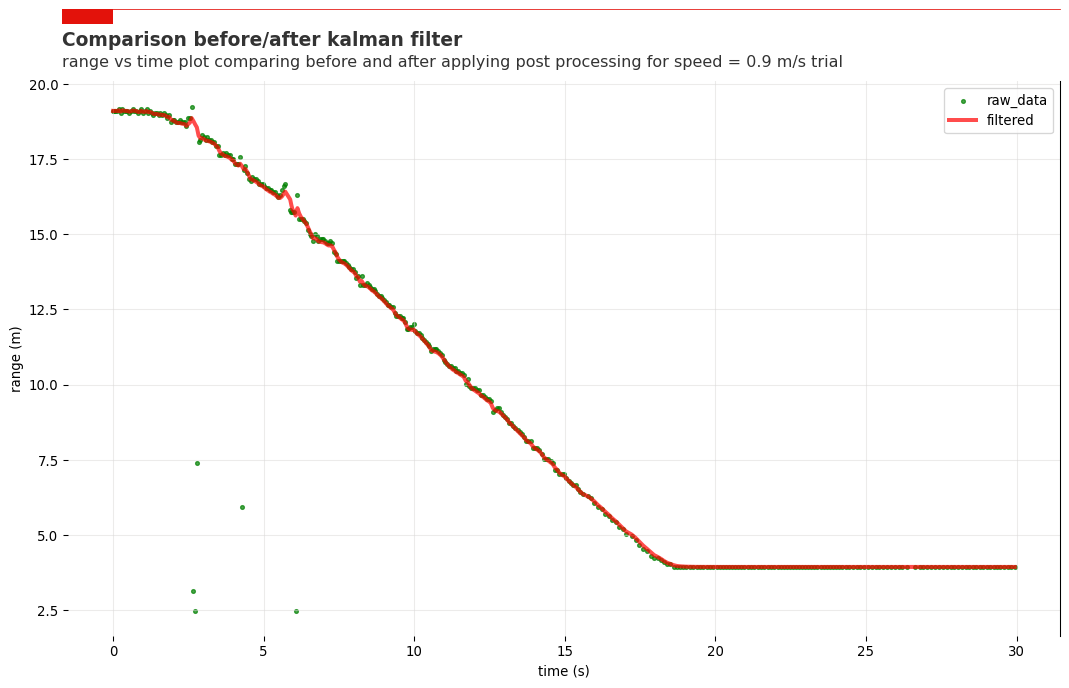

In [75]:
path = 'Data/' + names[6][28:-7] + '/processed_data.pickle'
with open(path, 'rb') as handle:
    data_dict = pickle.load(handle)
    
timestamp = data_dict['timestamp']
data_raw = data_dict['data_raw']
data_kalman = data_dict['data'][1]

fig, ax = plt.subplots(figsize=(13.33,7.5), dpi = 96)
ax.scatter(timestamp, data_raw, s = 8, c = 'g', alpha = 0.7)
ax.plot(timestamp, data_kalman, c = 'r', alpha = 0.7, linewidth=3)

ax.set_xlabel("time (s)")
ax.set_ylabel("range (m)")
ax.legend(['raw_data', 'filtered'])

ax.spines[['top','left','bottom']].set_visible(False)

ax.grid(which="major", axis='x', color='#DAD8D7', alpha=0.5, zorder=1)
ax.grid(which="major", axis='y', color='#DAD8D7', alpha=0.5, zorder=1)

ax.plot([0.12, .9], [.98, .98], transform=fig.transFigure, clip_on=False, color='#E3120B', linewidth=.6)
ax.add_patch(plt.Rectangle((0.12,.98), 0.04, -0.02, facecolor='#E3120B', transform=fig.transFigure, clip_on=False, linewidth = 0))

ax.text(x=0.12, y=.93, s="Comparison before/after kalman filter", transform=fig.transFigure, ha='left', fontsize=14, weight='bold', alpha=.8)
ax.text(x=0.12, y=.90, s="range vs time plot comparing before and after applying post processing for speed = 0.9 m/s trial", transform=fig.transFigure, ha='left', fontsize=12, alpha=.8)

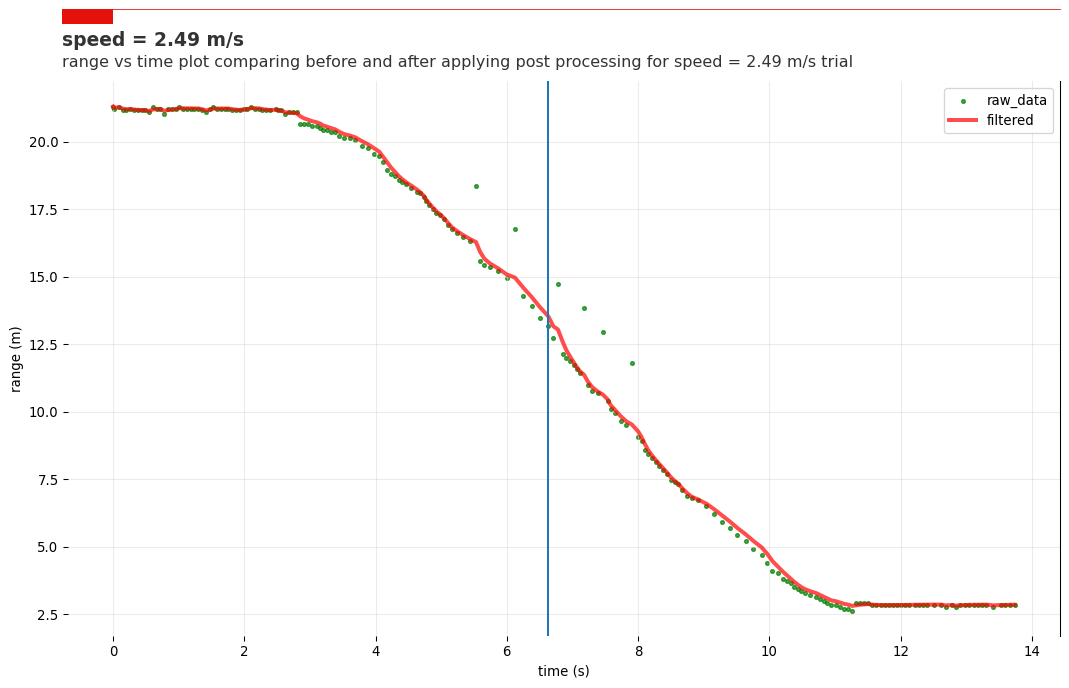

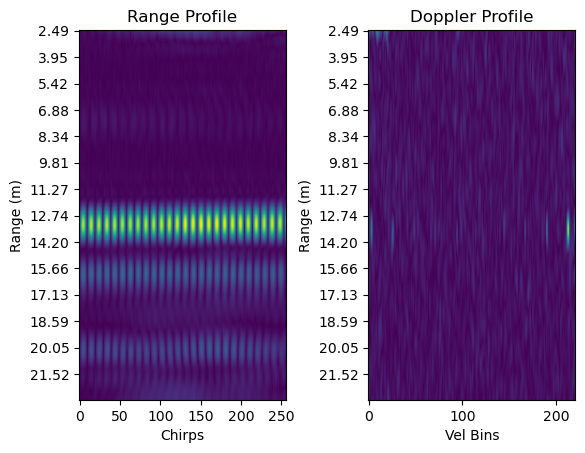

In [6]:
path = 'Data/' + names_good_outdoor[0][28:-7] + '/processed_data.pickle'
with open(path, 'rb') as handle:
    data_dict = pickle.load(handle)
    
timestamp = data_dict['timestamp'][:200]
data_raw = data_dict['data_raw'][:200]
data_kalman = data_dict['data'][1][:200]

fig, ax = plt.subplots(figsize=(13.33,7.5), dpi = 96)
ax.scatter(timestamp, data_raw, s = 8, c = 'g', alpha = 0.7)
ax.plot(timestamp, data_kalman, c = 'r', alpha = 0.7, linewidth=3)

ax.set_xlabel("time (s)")
ax.set_ylabel("range (m)")
ax.legend(['raw_data', 'filtered'])

ax.spines[['top','left','bottom']].set_visible(False)

ax.grid(which="major", axis='x', color='#DAD8D7', alpha=0.5, zorder=1)
ax.grid(which="major", axis='y', color='#DAD8D7', alpha=0.5, zorder=1)

ax.plot([0.12, .9], [.98, .98], transform=fig.transFigure, clip_on=False, color='#E3120B', linewidth=.6)
ax.add_patch(plt.Rectangle((0.12,.98), 0.04, -0.02, facecolor='#E3120B', transform=fig.transFigure, clip_on=False, linewidth = 0))

ax.text(x=0.12, y=.93, s="speed = 2.49 m/s", transform=fig.transFigure, ha='left', fontsize=14, weight='bold', alpha=.8)
ax.text(x=0.12, y=.90, s="range vs time plot comparing before and after applying post processing for speed = 2.49 m/s trial", transform=fig.transFigure, ha='left', fontsize=12, alpha=.8)

ax.axvline(x = timestamp[100])
utils.plot_doppler(names_good_outdoor[0], 100, save_fig = False, save_RD_norm = False, cut=[5,30], threshold = 0)


# Debug

(9, 241, 20.12766746826172, 3.150304706393322)

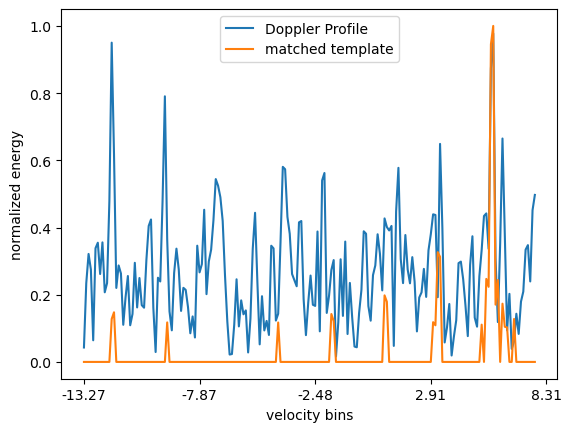

In [13]:
file = open(names_good_outdoor[0], 'rb')
data_raw = pickle.load(file)
file.close()
data_single_chn = data_raw['Data'][:,:,1]
cfg = data_raw['Cfg']
fc = (cfg['fStop'] + cfg['fStrt']) / 2
n_frame = data_single_chn.shape[1]
position = np.zeros(n_frame)
vel = np.zeros(n_frame)
nFFT = 2**10
nFFT_vel = 2**8

vFreqVel = np.arange(-nFFT_vel//2, nFFT_vel//2)/nFFT_vel*(1/cfg['Perd'])
vVel = (vFreqVel*utils.c0/(2*fc))[5:-5]




data_snapshot = data_single_chn[:,65]
RPExt, RD, vRangeExt = utils.get_RP_RD(data_snapshot, cfg, nFFT, nFFT_vel)

vRangeExtVisIdx = np.arange(0, vRangeExt.shape[0], 20)
vRangeExtVis = list(map(lambda x: "%.2f" % x, vRangeExt[vRangeExtVisIdx]))
vVelVisIdx = np.arange(0, vVel.shape[0], 50)
vVelVis = list(map(lambda x: "%.2f" % x, vVel[vVelVisIdx]))

RD = RD[:,30:-30]
RD_diff = np.abs(RD) - np.min(np.abs(RD))
RD_norm = RD_diff / np.max(np.abs(RD))
RD_norm[RD_norm < 0] = 0

velArr = np.arange(-5,5,0.1)
templateAll = utils.create_template(velArr, cfg, nFFT_vel)
templateAll = templateAll[:, 30:-30]

position, vel_i, range_idx, max_cor = utils.get_position(RD_norm, templateAll, vRangeExt)

plt.plot(RD_norm[range_idx])
plt.plot(templateAll[vel_i])
plt.legend(['Doppler Profile', 'matched template'])
plt.xlabel('velocity bins')
plt.ylabel('normalized energy')
plt.xticks(vVelVisIdx, labels=vVelVis)
vel_i, range_idx, position, max_cor